C:\Users\sfola\AppData\Local\Temp\ipykernel_35112\3903923429.py:37: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  self.derivatives = [derivative(p, 0) for p in self.polynomials]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


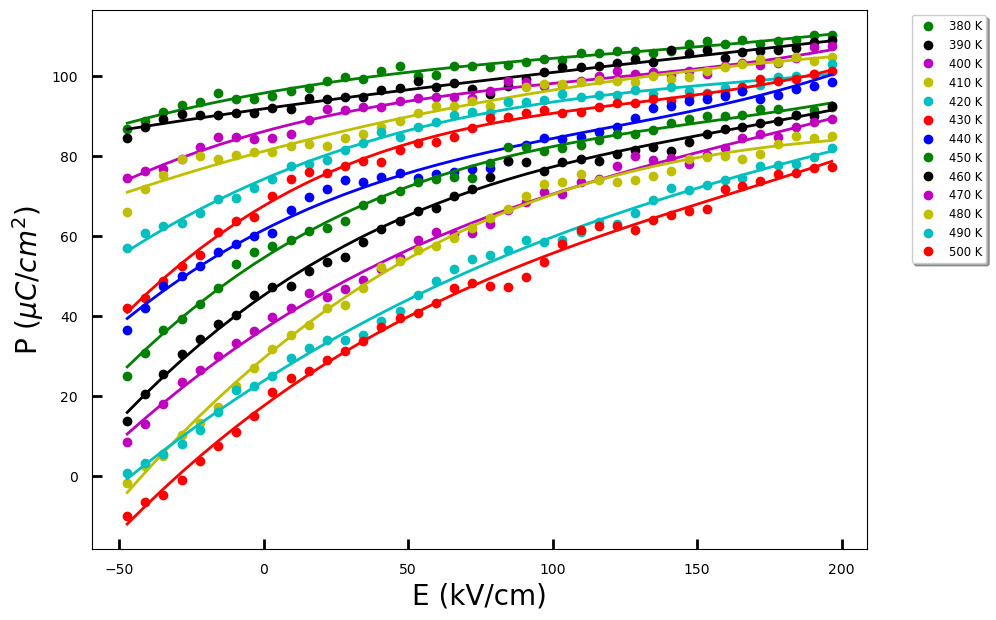

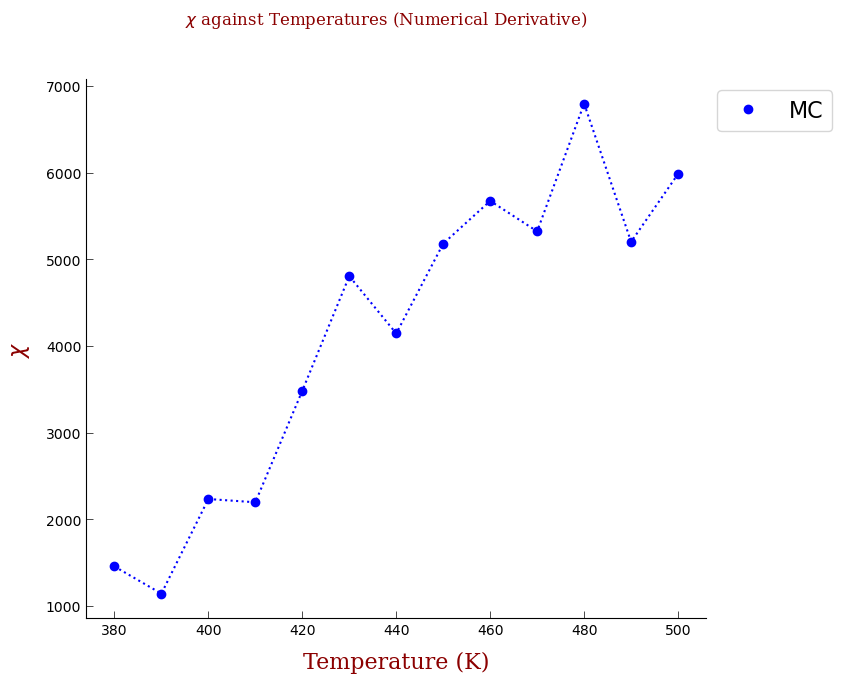

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative

class MCDataFitting:
    def __init__(self, filename, degree=3, save_plots=True):
        """
        Initializes the class with the data file, polynomial degree, and save settings.

        :param filename: Name of the file containing data.
        :param degree: Degree of the polynomial fit.
        :param save_plots: Whether to save plots as files.
        """
        self.filename = filename
        self.degree = degree
        self.save_plots = save_plots
        self.x = None
        self.y_values = None
        self.polynomials = []
        self.derivatives = []
        self.temperatures = np.arange(380, 510, 10)  # Adjust based on dataset

        self.load_data()
    
    def load_data(self):
        """Loads data from a text file and scales the y-values."""
        data = np.loadtxt(self.filename)
        self.x = data[:, 0]  # 1D array of x values
        self.y_values = -data[:, 1:14] * 1308  # Extract columns 1 to 13, scaling factor applied

    def fit_polynomials(self):
        """Fits a polynomial of degree `self.degree` to each dataset."""
        self.polynomials = [np.poly1d(np.polyfit(self.x, y, self.degree)) for y in self.y_values.T]

    def compute_derivatives(self):
        """Computes the first derivative at x = 0 for each fitted polynomial."""
        self.derivatives = [derivative(p, 0) for p in self.polynomials]
        np.savetxt('MC_fit.txt_0', self.derivatives)

    def plot_results(self):
        """Plots the original data along with the polynomial fits."""
        colors = ['g', 'k', 'm', 'y', 'c', 'r', 'b']
        fig, ax = plt.subplots(figsize=(10, 7))

        for i, (y, p, temp) in enumerate(zip(self.y_values.T, self.polynomials, self.temperatures)):
            color = colors[i % len(colors)]  # Cycle through colors
            ax.plot(self.x, y, 'o', color=color, lw=2, label=f'{temp} K')  # Raw data
            ax.plot(self.x, p(self.x), color=color, lw=2)  # Fitted curve

        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', shadow=True)
        ax.set_xlabel('E (kV/cm)', fontsize=20)
        ax.set_ylabel(r'P ($\mu C/cm^2$)', fontsize=20)
        ax.tick_params(direction='in', length=7, width=2, pad=10)

        if self.save_plots:
            plt.savefig('PE.eps', format='eps', dpi=300, bbox_inches='tight')
            plt.savefig('MC_fit.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

        plt.show()

    def plot_derivative_results(self):
        """Plots susceptibility (χ) vs. temperature using the derivative data."""
        try:
            my_25_mc = np.loadtxt('MC_fit.txt_0')
            mc = my_25_mc * 10**5 / 8.85  # Convert to susceptibility

            fig, ax = plt.subplots(figsize=(8, 7))
            ax.plot(self.temperatures, mc, "ob", label='MC')
            ax.plot(self.temperatures, mc, ":", color='b')

            font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16}
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.xaxis.set_tick_params(which='major', size=5, width=0.5, direction='in', bottom=True)
            ax.yaxis.set_tick_params(which='major', size=5, width=0.5, direction='in', left=True)

            plt.suptitle('$\chi$ against Temperatures (Numerical Derivative)', fontdict=font)
            ax.set_ylabel('$\chi$', fontdict=font, labelpad=10)
            ax.set_xlabel('Temperature (K)', fontdict=font, labelpad=10)
            ax.legend(loc='upper left', frameon=True, fontsize=16, bbox_to_anchor=(1.0, 1.0))

            if self.save_plots:
                plt.savefig('MC_susceptibility.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

            plt.show()
        except OSError:
            print("Error: MC_fit.txt_0 not found. Run `compute_derivatives()` first.")

    def run_analysis(self):
        """Runs the full analysis: polynomial fitting, derivative computation, and plotting."""
        self.fit_polynomials()
        self.compute_derivatives()
        self.plot_results()
        self.plot_derivative_results()

# Usage
analysis = MCDataFitting('MC_data.txt', degree=3, save_plots=True)
analysis.run_analysis()


C:\Users\sfola\AppData\Local\Temp\ipykernel_35112\1179765603.py:40: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  self.derivatives = [derivative(p, 0) for p in self.polynomials]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


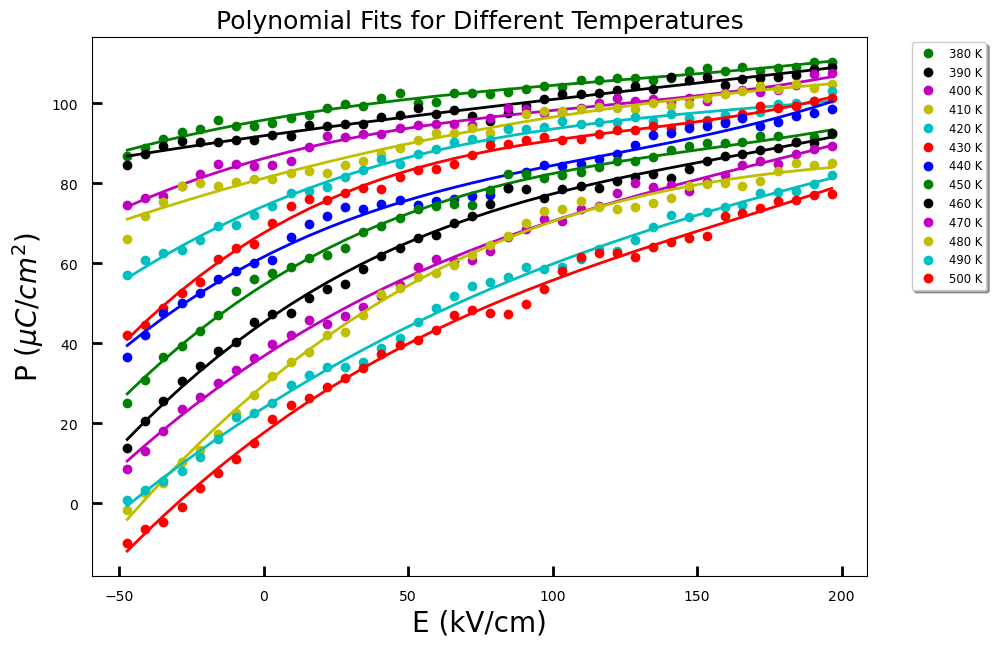

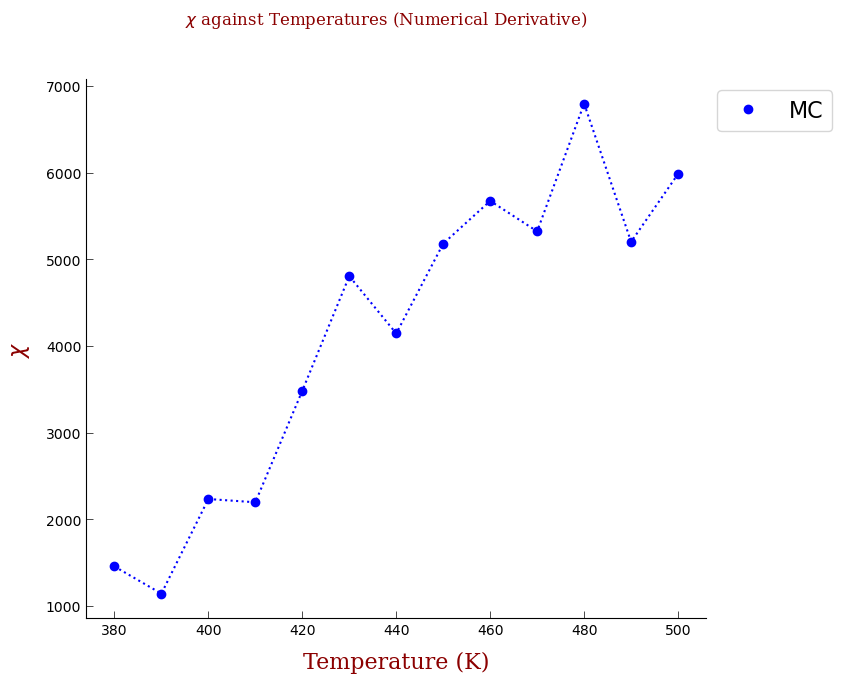

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative

class MCDataFitting:
    def __init__(self, filename, degree=3, save_plots=True):
        """
        Initializes the class with the data file, polynomial degree, and save settings.

        :param filename: Name of the file containing data.
        :param degree: Degree of the polynomial fit.
        :param save_plots: Whether to save plots as files.
        """
        self.filename = filename
        self.degree = degree
        self.save_plots = save_plots
        self.x = None
        self.y_values = None
        self.polynomials = []
        self.derivatives = []
        self.temperatures = np.arange(380, 510, 10)  # Adjust based on dataset

        self.load_data()
    
    def load_data(self):
        """Loads data from a text file and scales the y-values."""
        try:
            data = np.loadtxt(self.filename)
            self.x = data[:, 0]  # 1D array of x values
            self.y_values = -data[:, 1:14] * 1308  # Extract columns 1 to 13, scaling factor applied
        except Exception as e:
            print(f"Error loading data from {self.filename}: {e}")
    
    def fit_polynomials(self):
        """Fits a polynomial of degree `self.degree` to each dataset."""
        self.polynomials = [np.poly1d(np.polyfit(self.x, y, self.degree)) for y in self.y_values.T]

    def compute_derivatives(self):
        """Computes the first derivative at x = 0 for each fitted polynomial."""
        self.derivatives = [derivative(p, 0) for p in self.polynomials]
        np.savetxt('MC_fit.txt_0', self.derivatives)

    def plot_results(self):
        """Plots the original data along with the polynomial fits."""
        colors = ['g', 'k', 'm', 'y', 'c', 'r', 'b']
        fig, ax = plt.subplots(figsize=(10, 7))

        for i, (y, p, temp) in enumerate(zip(self.y_values.T, self.polynomials, self.temperatures)):
            color = colors[i % len(colors)]  # Cycle through colors
            ax.plot(self.x, y, 'o', color=color, lw=2, label=f'{temp} K')  # Raw data
            ax.plot(self.x, p(self.x), color=color, lw=2)  # Fitted curve

        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', shadow=True)
        ax.set_xlabel('E (kV/cm)', fontsize=20)
        ax.set_ylabel(r'P ($\mu C/cm^2$)', fontsize=20)
        ax.tick_params(direction='in', length=7, width=2, pad=10)
        ax.set_title('Polynomial Fits for Different Temperatures', fontsize=18)  # Add title

        if self.save_plots:
            plt.savefig('PE.eps', format='eps', dpi=300, bbox_inches='tight')
            plt.savefig('MC_fit.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

        plt.show()

    def plot_derivative_results(self):
        """Plots susceptibility (χ) vs. temperature using the derivative data."""
        try:
            my_25_mc = np.loadtxt('MC_fit.txt_0')
            mc = my_25_mc * 10**5 / 8.85  # Convert to susceptibility

            fig, ax = plt.subplots(figsize=(8, 7))
            ax.plot(self.temperatures, mc, "ob", label='MC')
            ax.plot(self.temperatures, mc, ":", color='b')

            font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16}
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.xaxis.set_tick_params(which='major', size=5, width=0.5, direction='in', bottom=True)
            ax.yaxis.set_tick_params(which='major', size=5, width=0.5, direction='in', left=True)

            plt.suptitle('$\chi$ against Temperatures (Numerical Derivative)', fontdict=font)
            ax.set_ylabel('$\chi$', fontdict=font, labelpad=10)
            ax.set_xlabel('Temperature (K)', fontdict=font, labelpad=10)
            ax.legend(loc='upper left', frameon=True, fontsize=16, bbox_to_anchor=(1.0, 1.0))

            if self.save_plots:
                plt.savefig('MC_susceptibility.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

            plt.show()
        except OSError:
            print("Error: MC_fit.txt_0 not found. Run `compute_derivatives()` first.")

    def run_analysis(self):
        """Runs the full analysis: polynomial fitting, derivative computation, and plotting."""
        self.fit_polynomials()
        self.compute_derivatives()
        self.plot_results()
        self.plot_derivative_results()

# Usage
analysis = MCDataFitting('MC_data.txt', degree=3, save_plots=True)
analysis.run_analysis()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming you've already defined your polynomials (f1, f2, ..., f12) for each temperature

def calculate_r_squared(x, y, poly):
    """Calculates the R-squared value for the polynomial fit."""
    y_pred = poly(x)  # predicted values
    return r2_score(y, y_pred)

def calculate_mse(x, y, poly):
    """Calculates the Mean Squared Error for the polynomial fit."""
    y_pred = poly(x)  # predicted values
    mse = np.mean((y - y_pred)**2)
    return mse

def plot_residuals(x, y, poly, temperature):
    """Plots the residuals for a polynomial fit."""
    y_pred = poly(x)
    residuals = y - y_pred
    plt.scatter(x, residuals, label=f'Residuals at {temperature} K', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('E (kV/cm)')
    plt.ylabel('Residuals (P - P_fit)')
    plt.legend()
    plt.title(f'Residuals for {temperature} K')

# List of polynomial fits for all temperatures (from 380 K to 500 K)
polynomials = [f, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12]
y_values = [y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12]
temperatures = np.arange(380, 510, 10)

# Initialize lists to store R-squared and MSE values
r_squared_values = []
mse_values = []

# Loop through each temperature and calculate R-squared, MSE, and plot residuals
for i, temp_poly in enumerate(polynomials):
    temperature = temperatures[i]
    y_temp = y_values[i]
    
    # Calculate R-squared and MSE
    r_squared = calculate_r_squared(x, y_temp, temp_poly)
    mse = calculate_mse(x, y_temp, temp_poly)
    
    # Store the values
    r_squared_values.append(r_squared)
    mse_values.append(mse)
    
    # Print the results for each temperature
    print(f"Temperature: {temperature} K")
    print(f"  R-squared: {r_squared:.4f}")
    print(f"  MSE: {mse:.4f}")
    
    # Plot residuals for each temperature
    plot_residuals(x, y_temp, temp_poly, temperature)

# Show residual plots
plt.show()

# Plot R-squared and MSE for all temperatures
fig, ax = plt.subplots(figsize=(8, 6))

# Plot R-squared
ax.plot(temperatures, r_squared_values, label='R-squared', marker='o', color='b')
ax.set_xlabel('Temperature (K)', fontsize=14)
ax.set_ylabel('R-squared', fontsize=14)
ax.set_title('R-squared for Different Temperatures', fontsize=16)
ax.legend()

plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

# Plot MSE
ax.plot(temperatures, mse_values, label='MSE', marker='s', color='r')
ax.set_xlabel('Temperature (K)', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
ax.set_title('MSE for Different Temperatures', fontsize=16)
ax.legend()

plt.show()


NameError: name 'f' is not defined

C:\Users\sfola\AppData\Local\Temp\ipykernel_35112\792958967.py:40: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  self.derivatives = [derivative(p, 0) for p in self.polynomials]


Temperature 380 K - MSE: 0.7131
Temperature 390 K - MSE: 1.2725
Temperature 400 K - MSE: 1.1021
Temperature 410 K - MSE: 2.4330
Temperature 420 K - MSE: 1.2405
Temperature 430 K - MSE: 1.2133
Temperature 440 K - MSE: 3.8611
Temperature 450 K - MSE: 1.6667
Temperature 460 K - MSE: 2.0771
Temperature 470 K - MSE: 2.0090
Temperature 480 K - MSE: 2.2365
Temperature 490 K - MSE: 2.0183
Temperature 500 K - MSE: 2.4740


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


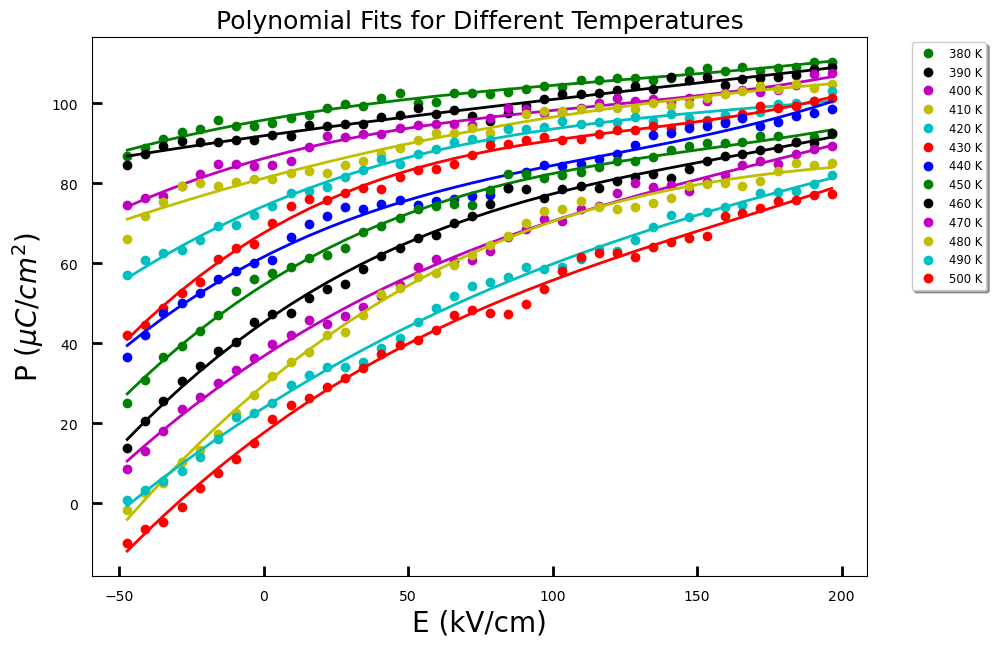

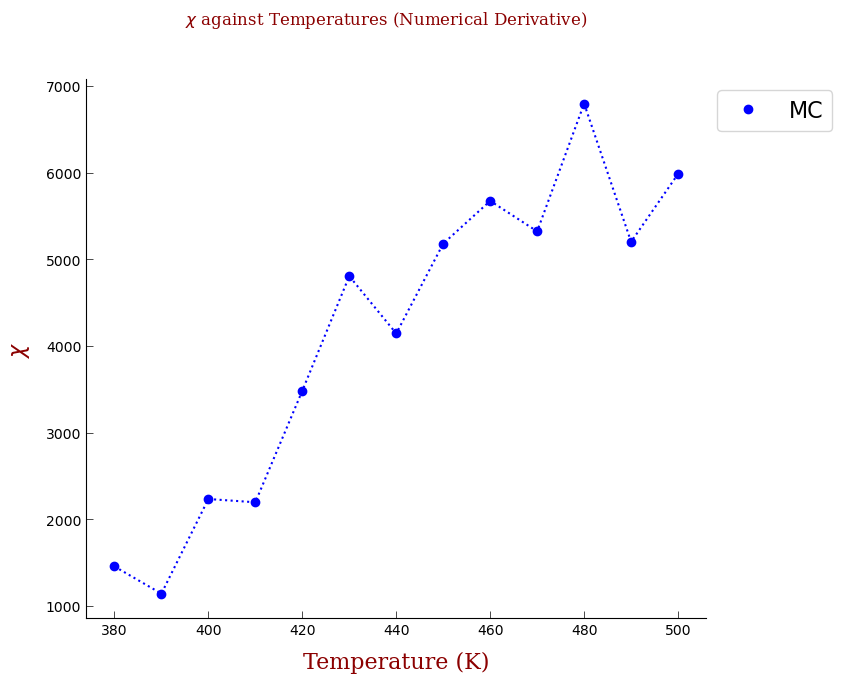

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative

class MCDataFitting:
    def __init__(self, filename, degree=3, save_plots=True):
        """
        Initializes the class with the data file, polynomial degree, and save settings.

        :param filename: Name of the file containing data.
        :param degree: Degree of the polynomial fit.
        :param save_plots: Whether to save plots as files.
        """
        self.filename = filename
        self.degree = degree
        self.save_plots = save_plots
        self.x = None
        self.y_values = None
        self.polynomials = []
        self.derivatives = []
        self.temperatures = np.arange(380, 510, 10)  # Adjust based on dataset

        self.load_data()
    
    def load_data(self):
        """Loads data from a text file and scales the y-values."""
        try:
            data = np.loadtxt(self.filename)
            self.x = data[:, 0]  # 1D array of x values
            self.y_values = -data[:, 1:14] * 1308  # Extract columns 1 to 13, scaling factor applied
        except Exception as e:
            print(f"Error loading data from {self.filename}: {e}")
    
    def fit_polynomials(self):
        """Fits a polynomial of degree `self.degree` to each dataset."""
        self.polynomials = [np.poly1d(np.polyfit(self.x, y, self.degree)) for y in self.y_values.T]

    def compute_derivatives(self):
        """Computes the first derivative at x = 0 for each fitted polynomial."""
        self.derivatives = [derivative(p, 0) for p in self.polynomials]
        np.savetxt('MC_fit.txt_0', self.derivatives)

    def compute_mse(self):
        """Computes the Mean Squared Error for each polynomial fit."""
        mse_values = []
        for i, (y, p) in enumerate(zip(self.y_values.T, self.polynomials)):
            y_pred = p(self.x)  # Predicted values from polynomial fit
            mse = np.mean((y - y_pred) ** 2)  # Compute MSE
            mse_values.append(mse)
            print(f"Temperature {self.temperatures[i]} K - MSE: {mse:.4f}")
        return mse_values

    def plot_results(self):
        """Plots the original data along with the polynomial fits."""
        colors = ['g', 'k', 'm', 'y', 'c', 'r', 'b']
        fig, ax = plt.subplots(figsize=(10, 7))

        for i, (y, p, temp) in enumerate(zip(self.y_values.T, self.polynomials, self.temperatures)):
            color = colors[i % len(colors)]  # Cycle through colors
            ax.plot(self.x, y, 'o', color=color, lw=2, label=f'{temp} K')  # Raw data
            ax.plot(self.x, p(self.x), color=color, lw=2)  # Fitted curve

        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', shadow=True)
        ax.set_xlabel('E (kV/cm)', fontsize=20)
        ax.set_ylabel(r'P ($\mu C/cm^2$)', fontsize=20)
        ax.tick_params(direction='in', length=7, width=2, pad=10)
        ax.set_title('Polynomial Fits for Different Temperatures', fontsize=18)  # Add title

        if self.save_plots:
            plt.savefig('PE.eps', format='eps', dpi=300, bbox_inches='tight')
            plt.savefig('MC_fit.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

        plt.show()

    def plot_derivative_results(self):
        """Plots susceptibility (χ) vs. temperature using the derivative data."""
        try:
            my_25_mc = np.loadtxt('MC_fit.txt_0')
            mc = my_25_mc * 10**5 / 8.85  # Convert to susceptibility

            fig, ax = plt.subplots(figsize=(8, 7))
            ax.plot(self.temperatures, mc, "ob", label='MC')
            ax.plot(self.temperatures, mc, ":", color='b')

            font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16}
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.xaxis.set_tick_params(which='major', size=5, width=0.5, direction='in', bottom=True)
            ax.yaxis.set_tick_params(which='major', size=5, width=0.5, direction='in', left=True)

            plt.suptitle('$\chi$ against Temperatures (Numerical Derivative)', fontdict=font)
            ax.set_ylabel('$\chi$', fontdict=font, labelpad=10)
            ax.set_xlabel('Temperature (K)', fontdict=font, labelpad=10)
            ax.legend(loc='upper left', frameon=True, fontsize=16, bbox_to_anchor=(1.0, 1.0))

            if self.save_plots:
                plt.savefig('MC_susceptibility.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

            plt.show()
        except OSError:
            print("Error: MC_fit.txt_0 not found. Run `compute_derivatives()` first.")

    def run_analysis(self):
        """Runs the full analysis: polynomial fitting, derivative computation, and plotting."""
        self.fit_polynomials()
        self.compute_derivatives()
        self.compute_mse()  # Compute and display MSE
        self.plot_results()
        self.plot_derivative_results()

# Usage
analysis = MCDataFitting('MC_data.txt', degree=3, save_plots=True)
analysis.run_analysis()
